<a href="https://colab.research.google.com/github/daspartho/DiffEdit/blob/main/DiffEdit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting things up

### Install and imports

In [264]:
!pip install diffusers transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [265]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
import torch
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from PIL import Image
from IPython import display
import logging
from pathlib import Path
from huggingface_hub import notebook_login

logging.disable(logging.WARNING)

if not (Path.home()/'.huggingface'/'token').exists(): 
    notebook_login()

### Loading the Models

In [266]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
)

text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
).to("cuda")

vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "vae",
    torch_dtype = torch.float16,
).to("cuda")

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "unet",
    torch_dtype = torch.float16,
).to("cuda")

beta_start,beta_end = 0.00085,0.012
scheduler = DDIMScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    clip_sample=False, 
    set_alpha_to_one=False,
)

### Useful functions

#### Functions to convert image to latents and vice-versa

In [267]:
def encode(img):
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(img).unsqueeze(0).to("cuda").half())
        latent = 0.18215 * latent.latent_dist.sample()
    return latent

def decode(latent):
    with torch.no_grad():
        img = vae.decode(latent).sample
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(0, 2, 3, 1).numpy()
    img = (img * 255).round().astype("uint8")
    return Image.fromarray(img[0])

#### Funtion to convert prompt into text embeddings

In [268]:
def prep_text(prompt):

    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    text_embedding = text_encoder(
        text_input.input_ids.to("cuda")
    )[0].half()

    uncond_input = tokenizer(
        [""],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    uncond_embedding = text_encoder(
        uncond_input.input_ids.to("cuda")
    )[0].half()

    return torch.cat([uncond_embedding, text_embedding])

## Step 1: Get the Mask

### Denoising function (basically Img2Img pipeline)

In [269]:
def denoise(
    prompt,
    img, 
    steps=50,
    guidance_scale=7.5, 
    start_step=25,
    seed=32
    ):

    prompt = [prompt]
    text_embeddings = prep_text(prompt)

    scheduler.set_timesteps(steps)

    width, height = img.size
    encoded = encode(img)

    torch.manual_seed(seed)
    noise = torch.randn(
        (1,unet.in_channels,height // 8,width // 8),
    ).to("cuda").half()

    latents = scheduler.add_noise(
        encoded, 
        noise, 
        timesteps=torch.tensor([scheduler.timesteps[start_step]])
    )

    for i, t in enumerate(tqdm(scheduler.timesteps)):
        if i > start_step:
            input = torch.cat([latents]*2)
            input = scheduler.scale_model_input(input, t)

            with torch.no_grad():
                pred = unet(
                    input, 
                    t,
                    encoder_hidden_states=text_embeddings,
                ).sample

            pred_uncond, pred_text = pred.chunk(2)
            pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

            latents = scheduler.step(pred, t, latents).prev_sample

    return (1 / 0.18215) * latents

### Get the input image

In [270]:
!curl --output test.jpg 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimages.unsplash.com%2Fphoto-1600352774373-7b992e5189de%3Fixid%3DMnwxMjA3fDB8MHxzZWFyY2h8MXx8c2l0dGluZyUyMGRvZ3xlbnwwfHwwfHw%253D%26ixlib%3Drb-1.2.1%26w%3D1000%26q%3D80&f=1&nofb=1&ipt=bebfda4f84f40b7bf4f1ebf742afbb8998a464defb426074ed4ffb821e329860&ipo=images'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125k    0  125k    0     0   632k      0 --:--:-- --:--:-- --:--:--  632k


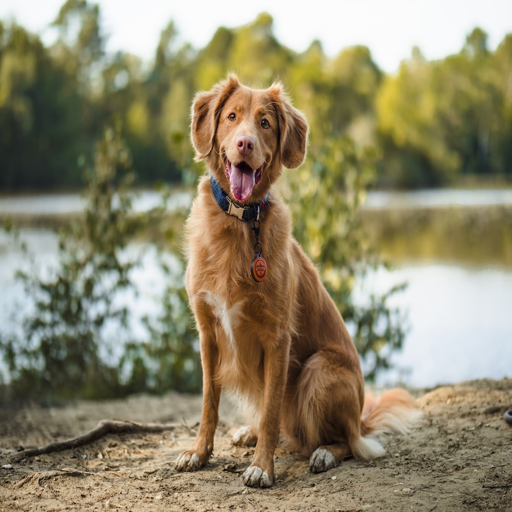

In [271]:
img = Image.open('test.jpg').resize((512, 512))
display.display(img)

### Denoising input image

In [272]:
ref = "a sitting dog"
query = "a sitting cat"

#### Denoising on query text

  0%|          | 0/50 [00:04<?, ?it/s]

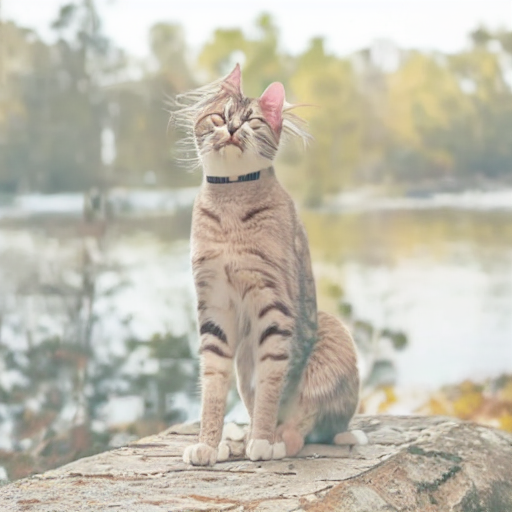

In [273]:
query_latents = denoise(query,img)
query_img = decode(query_latents)
display.display(query_img)

#### Denoising on reference text

  0%|          | 0/50 [00:00<?, ?it/s]

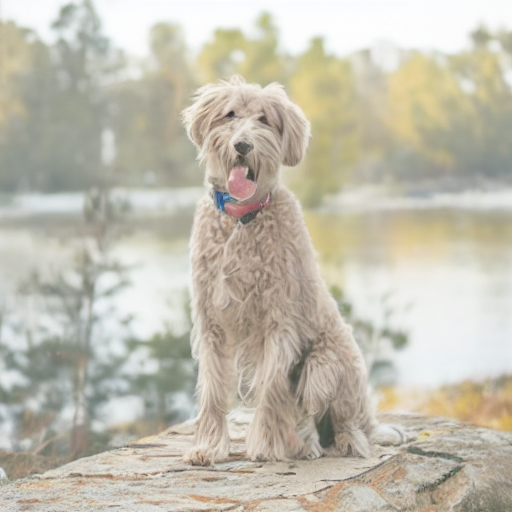

In [274]:
ref_latents = denoise(ref, img)
ref_img = decode(ref_latents)
display.display(ref_img)

### Getting difference between the denoised images

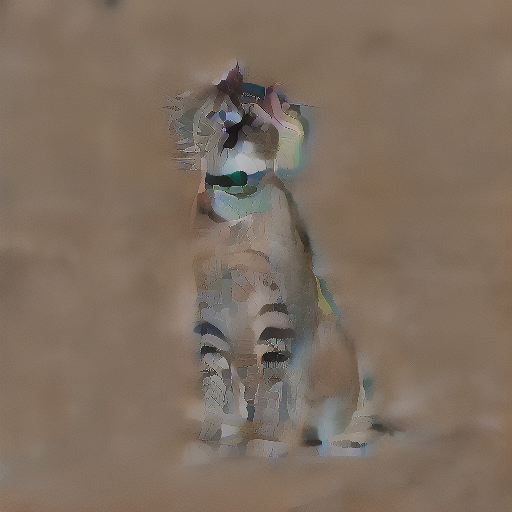

In [275]:
diff_latents = query_latents - ref_latents
diff_img = decode(diff_latents)
display.display(diff_img)

In [276]:
 def latent_to_array(latent):
    with torch.no_grad():
        img = vae.decode(latent).sample
    return img

In [277]:
def mk_img(img):
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(0, 2, 3, 1).numpy()
    img = (img * 255).round().astype("uint8")
    return Image.fromarray(img[0])

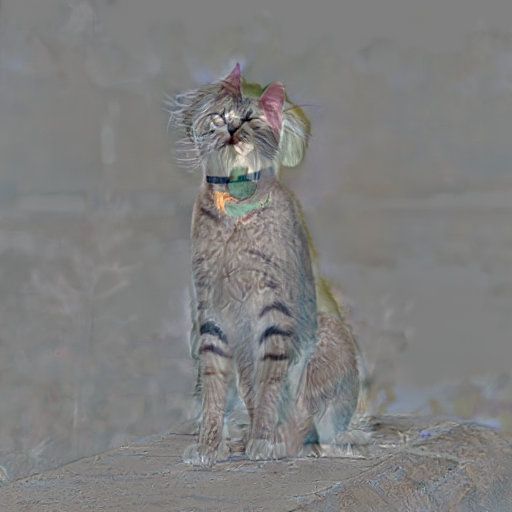

In [278]:
query_array = latent_to_array(query_latents)
ref_array = latent_to_array(ref_latents)
diff_array = query_array-ref_array
diff_img=mk_img(diff_array)
display.display(diff_img)